In [1]:
# checking if packages are installed and install them if they are not installed
import importlib
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = ["pandas", "numpy", "pmdarima", "plotly", "matplotlib", "scikit-learn", "scipy", 
            "xlsxwriter", "tensorflow", "seaborn", "statsmodels"]

for package in packages:
    try:
        dist = importlib.util.find_spec(package)
        found = dist is not None
    except ImportError:
        found = False
    if not found:
        install(package)

In [1]:
# importing all libraries

In [2]:
import pandas as pd
import numpy as np
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#import pmdarima as pm
from pmdarima import auto_arima
import plotly.graph_objects as go
import math
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from sklearn.model_selection import TimeSeriesSplit
import xlsxwriter
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.display.float_format = '{:.4f}'.format

2.12.0


In [4]:
# Select file to import
file_to_import='visitors' #visitors or unemployment
# specify whether to exclude COVID data and whether log transformation is required for the target variable
pre_covid=0 # 1 or 0
log_transformation=1

In [5]:
#loading data file
df = pd.read_csv(file_to_import+'.csv', index_col = ['Date'],parse_dates = ['Date'])

In [7]:
#  perform exclusion of COVID data (if required) and log transformation
name1='all'

#pre-covide
if pre_covid==1:
    df=df[:-36]
    name1='pre_covid'
if log_transformation==1:
    # log transformation
    df['y'] = np.log(df['y'])

# output file name (based on input file and COVID inclusion/exclusion)    
filename=name1+'_'+file_to_import+'.xlsx'

'all_visitors.xlsx'

In [9]:
# fill empty values with 0
df.fillna(0, inplace=True)

<Axes: xlabel='Date'>

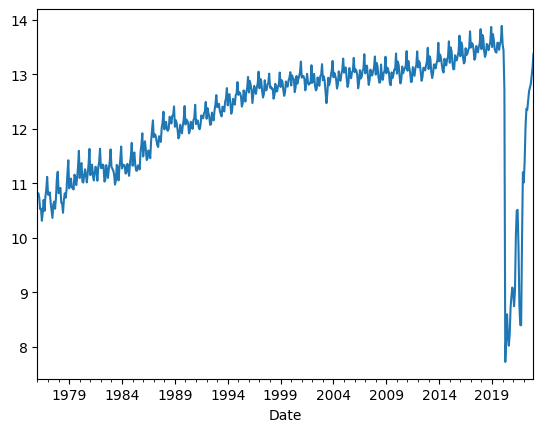

In [10]:
df['y'].plot()

In [11]:
#Basic information
df.info()
#Describe the data
df_info_all=df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1976-01-01 to 2022-12-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       564 non-null    float64
 1   G_U_1   564 non-null    float64
 2   G_U_2   564 non-null    float64
 3   G_U_3   564 non-null    float64
 4   G_U_4   564 non-null    float64
 5   G_U_5   564 non-null    float64
 6   G_U_6   564 non-null    float64
 7   G_U_7   564 non-null    float64
 8   G_U_8   564 non-null    float64
 9   G_U_9   564 non-null    float64
 10  G_U_10  564 non-null    float64
 11  G_U_11  564 non-null    float64
dtypes: float64(12)
memory usage: 57.3 KB


In [12]:
df_info_all

,y,G_U_1,G_U_2,G_U_3,G_U_4,G_U_5,G_U_6,G_U_7,G_U_8,G_U_9,G_U_10,G_U_11
count,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000,564.0000
mean,12.3092,12.8404,10.6454,10.6773,9.0514,16.9433,24.3280,10.1046,18.7784,13.9823,14.5089,10.7837
std,1.0687,18.2416,16.3739,17.6910,16.7380,21.9552,32.0146,19.1247,23.6846,18.5222,18.9278,15.2194
min,7.7187,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,11.6019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,12.7064,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,13.0560,25.0000,17.0000,17.0000,11.2500,40.0000,55.0000,11.0000,43.0000,31.0000,31.0000,22.0000
max,13.8904,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000


In [13]:
original_columns=df.columns
original_columns

Index(['y', 'G_U_1', 'G_U_2', 'G_U_3', 'G_U_4', 'G_U_5', 'G_U_6', 'G_U_7',
       'G_U_8', 'G_U_9', 'G_U_10', 'G_U_11'],
      dtype='object')

# Feature Engineering

In [14]:
# create 12 lags variables for each of the google indicators and for the target variable
df_lagged = df.copy()
trailing_window_size = 12

for window in range(1, trailing_window_size + 1):
    shifted = df.shift(window)
    shifted.columns = [x + "_l_" + str(window) for x in df.columns]
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [15]:
# create ten averages variables for the google indicators and the target variable
for x in original_columns:
    for i in range(3,13):
        df_lagged[x+'_avg'+str(i)] = df_lagged[x].rolling(i, min_periods=i).mean().shift()

In [16]:
df_lagged['month']=pd.to_datetime(df_lagged.index).month

In [17]:
df=df_lagged
unindexed_df=df.reset_index()

In [18]:
# four forecasting horizons
n=(3,6,12,24)
# index of data where Google trend data is populated
row_num=unindexed_df[unindexed_df.Date=='2004-01-01'].index

In [19]:
Google_col = [col for col in df if col.startswith('G_')]
target_col = [col for col in df if col.startswith('y_')]
Google_target_col=Google_col+target_col
engineered_fetaures = [x for x in Google_target_col if x not in original_columns]
engineered_fetaures.append('y')

In [20]:
#Basic information of all data including engineered features
df[row_num[0]+12:].info()
#Describe the data
df_info=df[row_num[0]+12:].describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2005-01-01 to 2022-12-01
Columns: 277 entries, y to month
dtypes: float64(276), int64(1)
memory usage: 469.1 KB


In [21]:
df_info

,y,G_U_1,G_U_2,G_U_3,G_U_4,G_U_5,G_U_6,G_U_7,G_U_8,G_U_9,...,G_U_11_avg4,G_U_11_avg5,G_U_11_avg6,G_U_11_avg7,G_U_11_avg8,G_U_11_avg9,G_U_11_avg10,G_U_11_avg11,G_U_11_avg12,month
count,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,...,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000,216.0000
mean,12.7709,29.6250,24.0463,23.6944,20.1157,41.0694,59.1111,21.6389,45.8287,33.3333,...,25.9549,25.9741,25.9931,25.9980,26.0052,26.0026,26.0190,26.0657,26.1111,6.5000
std,1.3010,11.5828,12.5048,14.9762,17.2030,10.9132,19.3072,18.4345,8.5128,9.9524,...,7.4096,7.0597,6.8476,6.7314,6.6811,6.6048,6.5337,6.5250,6.5297,3.4601
min,7.7187,15.0000,8.0000,7.0000,4.0000,0.0000,16.0000,4.0000,26.0000,12.0000,...,15.7500,16.2000,16.3333,16.0000,15.8750,16.1111,16.5000,16.7273,16.9167,1.0000
25%,12.9545,23.0000,15.0000,14.0000,10.0000,37.0000,48.0000,9.0000,39.7500,26.0000,...,20.5000,20.6000,20.8333,20.9643,20.9688,20.8889,20.8000,20.8864,20.8333,3.7500
50%,13.1218,26.0000,19.0000,19.0000,14.0000,42.0000,64.0000,14.0000,46.0000,34.0000,...,23.7500,23.6000,23.6667,24.1429,24.3125,24.3333,23.9500,24.0455,24.0417,6.5000
75%,13.3668,33.0000,32.0000,29.0000,25.0000,46.2500,74.0000,31.0000,52.0000,39.0000,...,30.7500,30.6000,30.7083,30.2857,30.3750,30.1389,30.2000,30.2727,30.4583,9.2500
max,13.8904,85.0000,71.0000,82.0000,100.0000,100.0000,100.0000,87.0000,67.0000,62.0000,...,56.7500,52.6000,50.8333,46.1429,48.2500,47.7778,47.1000,44.5455,43.0833,12.0000


# Feature Selection

In [23]:
from sklearn.feature_selection import f_regression, mutual_info_regression
import sklearn


In [24]:
def select_features(dataframe, col_list=engineered_fetaures, MIV_PCT=25, FTEST_PCT=10):
    train_fs=dataframe[row_num[0]:-24]
    train_fs_X=train_fs[col_list]
    train_y=train_fs_X.pop('y')
    
    #Use RFE to remove not significant features from the initial model.
    from sklearn.feature_selection import RFE
    from sklearn.tree import DecisionTreeRegressor
    selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=round(len(col_list)/2))
    selector = selector.fit(train_fs_X, train_y)
    RFE=pd.DataFrame(selector.support_,index=train_fs_X.columns)
    RFE.columns = ['RFE']
    mi_x=train_fs_X.to_numpy()
    mi_y=train_y.to_numpy()
    mi = mutual_info_regression(mi_x, mi_y)
    mi /= np.max(mi)
    f_test, _ = f_regression(mi_x, mi_y)
    f_test /= np.max(f_test)
    mi_df=pd.DataFrame(mi,index=train_fs_X.columns)
    mi_df.columns = ['MIV']
    f_df=pd.DataFrame(f_test, index=train_fs_X.columns)
    f_df.columns = ['F_test']
    Feature_Result = pd.concat([mi_df,f_df,RFE], axis=1)
    Feature_Result=abs(Feature_Result)
    Feature_Result.reset_index(drop=False, inplace=True)
    Feature_Result=Feature_Result[Feature_Result["RFE"] == True]
    Feature_sorted_MIV=Feature_Result.sort_values(["MIV"], ascending=[False])
    Feature_sorted_Ftest=Feature_Result.sort_values(["F_test"], ascending=[False])
    n_MIV=round(len(Feature_sorted_MIV)*MIV_PCT/100)
    n_Ftest=round(len(Feature_sorted_MIV)*FTEST_PCT/100)
    list_MIV=Feature_sorted_MIV.head(n_MIV)['index'].to_list()
    list_Ftest=Feature_sorted_Ftest.head(n_Ftest)['index'].to_list()
    final_list=list_MIV + list(set(list_Ftest) - set(list_MIV))
    target_list = [x for x in final_list if x.startswith("y_")]
    #google_list = [x for x in final_list if x.startswith("G_")]
    #google_list = [item[:5] for item in google_list]
    #google_list=list(set(google_list))
    return(final_list, target_list)

In [25]:
# listed of feature selection results
a,b=select_features(df,engineered_fetaures,25,10)

['y_l_12', 'y_l_4', 'y_l_1', 'y_l_7']

In [27]:
# feature selection for exogenous varibales
data=df[row_num[0]+12:][original_columns]
correlation_matrix = data.corr().abs()
print(correlation_matrix['y'])

# Select exogenous variables that have a correlation above a certain threshold, e.g., 0.4
selected_exog = correlation_matrix[correlation_matrix['y'] > 0.4].index
selected_exog = selected_exog.drop('y')  # drop 'y' itself
c=selected_exog.to_list()
print(c)

y        1.0000
G_U_1    0.2123
G_U_2    0.2846
G_U_3    0.2453
G_U_4    0.2052
G_U_5    0.4104
G_U_6    0.6056
G_U_7    0.1863
G_U_8    0.4114
G_U_9    0.4964
G_U_10   0.1815
G_U_11   0.1051
Name: y, dtype: float64
['G_U_5', 'G_U_6', 'G_U_8', 'G_U_9']


In [28]:
# store feature selection results in a dataframe
# Calculate the maximum length
max_length = max(len(a), len(b),len(c))

# Pad shorter lists with NaN
aa = a + [np.nan] * (max_length - len(a))
bb = b + [np.nan] * (max_length - len(b))
cc = c + [np.nan] * (max_length - len(c))
# Now we can create a DataFrame
selected_features = pd.DataFrame({
    'Combined_features': aa,
    'target_features': bb,
    'exogenous_variables':cc
})



In [22]:
# Creating empty dataframes to store forecasting results
prediction_results_3=pd.DataFrame()
prediction_results_6=pd.DataFrame()
prediction_results_12=pd.DataFrame()
prediction_results_24=pd.DataFrame()

# SARIMA

## using data (Historical) for training and testing on last 3,6,12 and 24 months


In [29]:
# finding the best parameters for SARIMA
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
# find the best parameters
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(df.y[:-24], order=param, seasonal_order=param_seasonal, enforce_stationarity=True, enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue

print('Best SARIMAX{}x{} model - AIC:{}'.format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(1, 1, 0, 12) model - AIC:-67.22378427690859


In [30]:
result_ARIMA_hist=pd.DataFrame()
MODEL=[]
VARS=[]
BIC=[]
AIC=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    train=df.y[:-i]
    test=df.y[-i:]
    # Seasonal - fit stepwise auto-ARIMA
    # Define and fit the SARIMA model
    ln = len(df)
    train_size = len(train)
    sarima_model = SARIMAX(train, order=best_pdq, seasonal_order=best_seasonal_pdq)
    sarima_results = sarima_model.fit(disp=False)
    sarima_pred = sarima_results.predict(start=train_size, end=ln-1)
    id_string="ARIMA_HIST_"+str(i)
    if i==3:
        prediction_results_3[id_string]=sarima_pred
    if i==6:
        prediction_results_6[id_string]=sarima_pred
    if i==12:
        prediction_results_12[id_string]=sarima_pred
    if i==24:
        prediction_results_24[id_string]=sarima_pred
    ID.append(id_string)
    VARS.append("INDICATOR")
    MODEL.append('Best SARIMA{}x{}'.format(best_pdq, best_seasonal_pdq))
    AIC.append(sarima_results.aic)
    BIC.append(sarima_results.bic)
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test, sarima_pred))
    SMAPE.append(smape(test, sarima_pred))
result_ARIMA_hist["ID"]=ID
result_ARIMA_hist["MODEL"]=MODEL
result_ARIMA_hist["VARS"]=VARS
result_ARIMA_hist["BIC"]=BIC
result_ARIMA_hist["AIC"]=AIC
result_ARIMA_hist["MSE"]=MSE
result_ARIMA_hist["SMAPE"]=SMAPE
result_ARIMA_hist["FORC_HORIZON"]=FORC_HORIZON

## using data from 2015 for training and testing on last 3,6,12 and 24 months

In [31]:
# finding the best combination of SARIMA parameters
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
# find the best parameters
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(df.y[row_num[0]+12:-24], order=param, seasonal_order=param_seasonal, enforce_stationarity=True, enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue

print('Best SARIMAX{}x{} model - AIC:{}'.format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(0, 1, 0, 12) model - AIC:161.26754353264064


In [32]:

result_ARIMA_recent=pd.DataFrame()
MODEL=[]
VARS=[]
BIC=[]
AIC=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    tmp_df=df.y[row_num[0]+12:]
    train=df.y[row_num[0]+12:-i]
    test=df.y[-i:]
    ln = len(tmp_df)
    train_size = len(train)
    sarima_model = SARIMAX(train, order=best_pdq, seasonal_order=best_seasonal_pdq)
    sarima_results = sarima_model.fit(disp=False)
    sarima_pred = sarima_results.predict(start=train_size, end=ln-1)
    id_string="ARIMA_RECENT_"+str(i)
    if i==3:
        prediction_results_3[id_string]=sarima_pred
    if i==6:
        prediction_results_6[id_string]=sarima_pred
    if i==12:
        prediction_results_12[id_string]=sarima_pred
    if i==24:
        prediction_results_24[id_string]=sarima_pred    
    ID.append(id_string)
    VARS.append("INDICATOR")
    MODEL.append('Best SARIMA{}x{}'.format(best_pdq, best_seasonal_pdq))
    AIC.append(sarima_results.aic)
    BIC.append(sarima_results.bic)
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test, sarima_pred))
    SMAPE.append(smape(test, sarima_pred))
    #print('test')
    #print(test)
    #print('pred')
    #print(safitted)
result_ARIMA_recent["ID"]=ID
result_ARIMA_recent["MODEL"]=MODEL
result_ARIMA_recent["VARS"]=VARS
result_ARIMA_recent["BIC"]=BIC
result_ARIMA_recent["AIC"]=AIC
result_ARIMA_recent["MSE"]=MSE
result_ARIMA_recent["SMAPE"]=SMAPE
result_ARIMA_recent["FORC_HORIZON"]=FORC_HORIZON

# SARIMAX

## using all exogenous variables

In [33]:
exogenous_features=original_columns.drop('y').to_list()

In [34]:
result_SARIMAX_ALL=pd.DataFrame()
MODEL=[]
VARS=[]
BIC=[]
AIC=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]

ID=[]
id=0

for i in n:
    id=id+1
    tmp_df=df[row_num[0]+12:]
    train=df[row_num[0]+12:-i]
    test=df[-i:]
    ln = len(tmp_df)
    train_size = len(train)
    sarimax_model = SARIMAX(train['y'], exog=train[exogenous_features], order=best_pdq, seasonal_order=best_seasonal_pdq)
    sarimax_results = sarimax_model.fit(disp=False)
    sarimax_pred = sarimax_results.predict(start=train_size, end=ln-1, exog=test[exogenous_features])
    id_string="SARIMAX_ALL_"+str(i)
    if i==3:
        prediction_results_3[id_string]=sarimax_pred
    if i==6:
        prediction_results_6[id_string]=sarimax_pred
    if i==12:
        prediction_results_12[id_string]=sarimax_pred
    if i==24:
        prediction_results_24[id_string]=sarimax_pred 
    ID.append(id_string)
    VARS.append(original_columns.drop('y'))
    MODEL.append('Best SARIMAX{}x{}'.format(best_pdq, best_seasonal_pdq))
    AIC.append(sarimax_results.aic)
    BIC.append(sarimax_results.bic)
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test.y, sarimax_pred))
    SMAPE.append(smape(test.y, sarimax_pred))
result_SARIMAX_ALL["ID"]=ID        
result_SARIMAX_ALL["MODEL"]=MODEL
result_SARIMAX_ALL["VARS"]=VARS
result_SARIMAX_ALL["BIC"]=BIC
result_SARIMAX_ALL["AIC"]=AIC
result_SARIMAX_ALL["MSE"]=MSE
result_SARIMAX_ALL["SMAPE"]=SMAPE
result_SARIMAX_ALL["FORC_HORIZON"]=FORC_HORIZON

# SARIMAX - Feature selection


In [35]:
result_SARIMAX_FS=pd.DataFrame()
MODEL=[]
VARS=[]
BIC=[]
AIC=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]

ID=[]
id=0

for i in n:
    id=id+1
    tmp_df=df[row_num[0]+12:]
    train=df[row_num[0]+12:-i]
    test=df[-i:]
    ln = len(tmp_df)
    train_size = len(train)
    sarimax_model = SARIMAX(train['y'], exog=train[c], order=best_pdq, seasonal_order=best_seasonal_pdq)
    sarimax_results = sarimax_model.fit(disp=False)
    sarimax_pred = sarimax_results.predict(start=train_size, end=ln-1, exog=test[c])
    id_string="SARIMAX_FS_"+str(i)
    if i==3:
        prediction_results_3[id_string]=sarimax_pred
    if i==6:
        prediction_results_6[id_string]=sarimax_pred
    if i==12:
        prediction_results_12[id_string]=sarimax_pred
    if i==24:
        prediction_results_24[id_string]=sarimax_pred 
    ID.append(id_string)
    VARS.append(c)
    MODEL.append('Best SARIMAX{}x{}'.format(best_pdq, best_seasonal_pdq))
    AIC.append(sarimax_results.aic)
    BIC.append(sarimax_results.bic)
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test.y, sarimax_pred))
    SMAPE.append(smape(test.y, sarimax_pred))
result_SARIMAX_FS["ID"]=ID        
result_SARIMAX_FS["MODEL"]=MODEL
result_SARIMAX_FS["VARS"]=VARS
result_SARIMAX_FS["BIC"]=BIC
result_SARIMAX_FS["AIC"]=AIC
result_SARIMAX_FS["MSE"]=MSE
result_SARIMAX_FS["SMAPE"]=SMAPE
result_SARIMAX_FS["FORC_HORIZON"]=FORC_HORIZON

# SVR using all target features

In [36]:
result_SVR_target_ALL=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    X_train=df.iloc[:,df.columns.str.startswith("y_")][row_num[0]+12:-i]
    X_test=df.iloc[:,df.columns.str.startswith("y_")][-i:]
    y_train=df[row_num[0]+12:-i]['y']
    y_test=df.y[-i:]
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_test.reset_index(drop=True, inplace=True)
    #print('test')
    #print(y_test)
    #print('pred')
    #print(y_pred)
    id_string="SVR_TARGET_ALL_"+str(i)
    if i==3:
        prediction_results_3[id_string]=y_pred
    if i==6:
        prediction_results_6[id_string]=y_pred
    if i==12:
        prediction_results_12[id_string]=y_pred
    if i==24:
        prediction_results_24[id_string]=y_pred    
    ID.append(id_string)
    VARS.append("Y_ALL")
    MODEL.append("SVR_Y_ALL")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(y_test, y_pred))
    SMAPE.append(smape(y_test, y_pred))

result_SVR_target_ALL["ID"]=ID
result_SVR_target_ALL["MODEL"]=MODEL
result_SVR_target_ALL["VARS"]=VARS
result_SVR_target_ALL["MSE"]=MSE
result_SVR_target_ALL["SMAPE"]=SMAPE
result_SVR_target_ALL["FORC_HORIZON"]=FORC_HORIZON

# SVR using  target features - FS


In [37]:
result_SVR_target_FS=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    X_train=df[row_num[0]+12:-i][b]
    X_test=df[-i:][b]
    y_train=df[row_num[0]+12:-i]['y']
    y_test=df.y[-i:]
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_test.reset_index(drop=True, inplace=True)
    #print('test')
    #print(y_test)
    #print('pred')
    #print(y_pred)
    id_string="SVR_TARGET_FS_"+str(i)
    if i==3:
        prediction_results_3[id_string]=y_pred
    if i==6:
        prediction_results_6[id_string]=y_pred
    if i==12:
        prediction_results_12[id_string]=y_pred
    if i==24:
        prediction_results_24[id_string]=y_pred    
    ID.append(id_string)
    VARS.append(b)
    MODEL.append("SVR_Y_FS")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(y_test, y_pred))
    SMAPE.append(smape(y_test, y_pred))

result_SVR_target_FS["ID"]=ID
result_SVR_target_FS["MODEL"]=MODEL
result_SVR_target_FS["VARS"]=VARS
result_SVR_target_FS["MSE"]=MSE
result_SVR_target_FS["SMAPE"]=SMAPE
result_SVR_target_FS["FORC_HORIZON"]=FORC_HORIZON

# SVR using target + GI all

In [38]:
result_SVR_TARGET_GI_ALL=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    X_train=df[row_num[0]+12:-i].drop(original_columns, axis=1)
    X_test=df[-i:].drop(original_columns, axis=1)
    y_train=df[row_num[0]+12:-i]['y']
    y_test=df.y[-i:]
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_test.reset_index(drop=True, inplace=True)
    #print('test')
    #print(y_test)
    #print('pred')
    #print(y_pred)
    id_string="SVR_TARGET_GI_ALL_"+str(i)
    if i==3:
        prediction_results_3[id_string]=y_pred
    if i==6:
        prediction_results_6[id_string]=y_pred
    if i==12:
        prediction_results_12[id_string]=y_pred
    if i==24:
        prediction_results_24[id_string]=y_pred    
    ID.append(id_string)
    VARS.append("Y_GI_ALL_")
    MODEL.append("SVR_Y_GI_ALL")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(y_test, y_pred))
    SMAPE.append(smape(y_test, y_pred))

result_SVR_TARGET_GI_ALL["ID"]=ID
result_SVR_TARGET_GI_ALL["MODEL"]=MODEL
result_SVR_TARGET_GI_ALL["VARS"]=VARS
result_SVR_TARGET_GI_ALL["MSE"]=MSE
result_SVR_TARGET_GI_ALL["SMAPE"]=SMAPE
result_SVR_TARGET_GI_ALL["FORC_HORIZON"]=FORC_HORIZON    

# SVR using target + GI - FS

In [39]:
result_SVR_TARGET_GI_FS=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    X_train=df[row_num[0]+12:-i][a]
    X_test=df[-i:][a]
    y_train=df[row_num[0]+12:-i]['y']
    y_test=df.y[-i:]
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_test.reset_index(drop=True, inplace=True)
    #print('test')
    #print(y_test)
    #print('pred')
    #print(y_pred)
    id_string="SVR_TARGET_GI_FS_"+str(i)
    if i==3:
        prediction_results_3[id_string]=y_pred
    if i==6:
        prediction_results_6[id_string]=y_pred
    if i==12:
        prediction_results_12[id_string]=y_pred
    if i==24:
        prediction_results_24[id_string]=y_pred    
    ID.append(id_string)
    VARS.append(a)
    MODEL.append("SVR_Y_GI_FS")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(y_test, y_pred))
    SMAPE.append(smape(y_test, y_pred))

result_SVR_TARGET_GI_FS["ID"]=ID
result_SVR_TARGET_GI_FS["MODEL"]=MODEL
result_SVR_TARGET_GI_FS["VARS"]=VARS
result_SVR_TARGET_GI_FS["MSE"]=MSE
result_SVR_TARGET_GI_FS["SMAPE"]=SMAPE
result_SVR_TARGET_GI_FS["FORC_HORIZON"]=FORC_HORIZON  

# CNN using all target features


In [40]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model


In [41]:
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
result_CNN_target_ALL=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    train_dataset=df.iloc[:,df.columns.str.startswith("y")][row_num[0]+12:-i]
    test_dataset=df.iloc[:,df.columns.str.startswith("y")][-i:]
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = train_features.pop('y')
    test_labels = test_features.pop('y')
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))
    dnn_model = build_and_compile_model(normalizer)
    #%%time
    dnn_model.fit(train_features,train_labels,verbose=0, epochs=100)
    #test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
    print(dnn_model.evaluate(test_features, test_labels, verbose=0))
    test_predictions = dnn_model.predict(test_features).flatten()
    id_string="CNN_TARGET_ALL"+str(i)
    if i==3:
        prediction_results_3[id_string]=test_predictions
    if i==6:
        prediction_results_6[id_string]=test_predictions
    if i==12:
        prediction_results_12[id_string]=test_predictions
    if i==24:
        prediction_results_24[id_string]=test_predictions    
    ID.append(id_string)
    VARS.append("Y_ALL")
    MODEL.append("CNN_Y_ALL")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test_labels, test_predictions))
    SMAPE.append(smape(test_labels, test_predictions))
    
result_CNN_target_ALL["ID"]=ID    
result_CNN_target_ALL["MODEL"]=MODEL
result_CNN_target_ALL["VARS"]=VARS
result_CNN_target_ALL["MSE"]=MSE
result_CNN_target_ALL["SMAPE"]=SMAPE
result_CNN_target_ALL["FORC_HORIZON"]=FORC_HORIZON  

1.0221840143203735
1/1 [==============================] - 0s 78ms/step
1.035056710243225
1/1 [==============================] - 0s 63ms/step
2.209014892578125
1/1 [==============================] - 0s 47ms/step
41.37403869628906
1/1 [==============================] - 0s 47ms/step


# CNN using  target features FS


In [42]:
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
result_CNN_target_FS=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    train_features=df[row_num[0]+12:-i][b]
    test_features=df[-i:][b]
    train_labels = df[row_num[0]+12:-i]['y']
    test_labels = df[-i:]['y']
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))
    dnn_model = build_and_compile_model(normalizer)
    #%%time
    dnn_model.fit(train_features,train_labels,verbose=0, epochs=100)
    #test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
    print(dnn_model.evaluate(test_features, test_labels, verbose=0))
    test_predictions = dnn_model.predict(test_features).flatten()
    id_string="CNN_TARGET_FS_"+str(i)
    if i==3:
        prediction_results_3[id_string]=test_predictions
    if i==6:
        prediction_results_6[id_string]=test_predictions
    if i==12:
        prediction_results_12[id_string]=test_predictions
    if i==24:
        prediction_results_24[id_string]=test_predictions    
    ID.append(id_string)
    MODEL.append("Target_FEATURES_FS")
    VARS.append(b)
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test_labels, test_predictions))
    SMAPE.append(smape(test_labels, test_predictions))
    
result_CNN_target_FS["ID"]=ID    
result_CNN_target_FS["MODEL"]=MODEL
result_CNN_target_FS["VARS"]=VARS
result_CNN_target_FS["MSE"]=MSE
result_CNN_target_FS["SMAPE"]=SMAPE
result_CNN_target_FS["FORC_HORIZON"]=FORC_HORIZON  

1.365928292274475
1/1 [==============================] - 0s 60ms/step
0.8700043559074402
1/1 [==============================] - 0s 46ms/step
1.9222255945205688
1/1 [==============================] - 0s 60ms/step
30.5708065032959
1/1 [==============================] - 0s 62ms/step


# CNN using all features (GI+TARGET)


In [43]:
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
result_CNN_TARGET_GI_ALL=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    train_dataset=df[row_num[0]+12:-i].drop(original_columns.drop('y'), axis=1)
    test_dataset=df[-i:].drop(original_columns.drop('y'), axis=1)
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = train_features.pop('y')
    test_labels = test_features.pop('y')
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))
    dnn_model = build_and_compile_model(normalizer)
    #%%time
    dnn_model.fit(train_features,train_labels,verbose=0, epochs=100)
    #test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
    print(dnn_model.evaluate(test_features, test_labels, verbose=0))
    test_predictions = dnn_model.predict(test_features).flatten()
    id_string="CNN_ALL_"+str(i)
    if i==3:
        prediction_results_3[id_string]=test_predictions
    if i==6:
        prediction_results_6[id_string]=test_predictions
    if i==12:
        prediction_results_12[id_string]=test_predictions
    if i==24:
        prediction_results_24[id_string]=test_predictions    
    ID.append(id_string)
    VARS.append("Y_GI_ALL")
    MODEL.append("CNN_GI_Y_ALL")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test_labels, test_predictions))
    SMAPE.append(smape(test_labels, test_predictions))
    
result_CNN_TARGET_GI_ALL["ID"]=ID    
result_CNN_TARGET_GI_ALL["MODEL"]=MODEL
result_CNN_TARGET_GI_ALL["VARS"]=VARS
result_CNN_TARGET_GI_ALL["MSE"]=MSE
result_CNN_TARGET_GI_ALL["SMAPE"]=SMAPE
result_CNN_TARGET_GI_ALL["FORC_HORIZON"]=FORC_HORIZON  

0.285290390253067
1/1 [==============================] - 0s 47ms/step
1.8548539876937866
1/1 [==============================] - 0s 47ms/step
2.547417640686035
1/1 [==============================] - 0s 54ms/step
17.441017150878906
1/1 [==============================] - 0s 48ms/step


# CNN using GI+TARGET - FS


In [44]:
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
result_CNN_TARGET_GI_FS=pd.DataFrame()
MODEL=[]
VARS=[]
MSE=[]
SMAPE=[]
FORC_HORIZON=[]
ID=[]
id=0

for i in n:
    id=id+1
    train_features=df[row_num[0]+12:-i][a]
    test_features=df[-i:][a]
    train_labels = df[row_num[0]+12:-i]['y']
    test_labels = df[-i:]['y']
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))
    dnn_model = build_and_compile_model(normalizer)
    #%%time
    dnn_model.fit(train_features,train_labels,verbose=0, epochs=100)
    #test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
    print(dnn_model.evaluate(test_features, test_labels, verbose=0))
    test_predictions = dnn_model.predict(test_features).flatten()
    id_string="CNN_TARGET_GI_FS_"+str(i)
    if i==3:
        prediction_results_3[id_string]=test_predictions
    if i==6:
        prediction_results_6[id_string]=test_predictions
    if i==12:
        prediction_results_12[id_string]=test_predictions
    if i==24:
        prediction_results_24[id_string]=test_predictions    
    ID.append(id_string)
    VARS.append(a)
    MODEL.append("CNN_Y_GI_FS")
    FORC_HORIZON.append(i)
    MSE.append(mean_squared_error(test_labels, test_predictions))
    SMAPE.append(smape(test_labels, test_predictions))
    
result_CNN_TARGET_GI_FS["ID"]=ID    
result_CNN_TARGET_GI_FS["MODEL"]=MODEL
result_CNN_TARGET_GI_FS["VARS"]=VARS
result_CNN_TARGET_GI_FS["MSE"]=MSE
result_CNN_TARGET_GI_FS["SMAPE"]=SMAPE
result_CNN_TARGET_GI_FS["FORC_HORIZON"]=FORC_HORIZON  

0.11066818237304688
1/1 [==============================] - 0s 53ms/step
0.3623313903808594
1/1 [==============================] - 0s 60ms/step
1.6427502632141113
1/1 [==============================] - 0s 59ms/step
19.469070434570312
1/1 [==============================] - 0s 47ms/step


# all models forecasted values -- comparison

In [45]:
prediction_results_3['y']=df[-3:].y
prediction_results_3

,ARIMA_HIST_3,ARIMA_RECENT_3,SARIMAX_ALL_3,SARIMAX_FS_3,SVR_TARGET_ALL_3,SVR_TARGET_FS_3,SVR_TARGET_GI_ALL_3,SVR_TARGET_GI_FS_3,CNN_TARGET_ALL3,CNN_TARGET_FS_3,CNN_ALL_3,CNN_TARGET_GI_FS_3,y
2022-10-01,13.0885,12.8217,12.6083,12.6929,11.9287,12.2671,12.7934,12.7856,12.4169,13.5803,12.7082,12.6970,12.9726
2022-11-01,13.9228,14.3757,13.9735,14.1593,11.7799,11.9610,12.8306,12.8282,11.7824,11.9760,12.8777,13.1001,13.1328
2022-12-01,14.5835,15.6323,15.2056,15.3642,11.9150,11.7997,12.8282,12.8464,12.2228,11.0497,13.0469,13.3596,13.3831


In [46]:
prediction_results_6['y']=df[-6:].y
prediction_results_6

,ARIMA_HIST_6,ARIMA_RECENT_6,SARIMAX_ALL_6,SARIMAX_FS_6,SVR_TARGET_ALL_6,SVR_TARGET_FS_6,SVR_TARGET_GI_ALL_6,SVR_TARGET_GI_FS_6,CNN_TARGET_ALL6,CNN_TARGET_FS_6,CNN_ALL_6,CNN_TARGET_GI_FS_6,y
2022-07-01,11.9824,11.8505,12.1953,12.0885,11.4394,11.4741,12.3006,12.3221,12.4397,11.0338,11.7903,13.1021,12.6937
2022-08-01,11.3940,10.7757,11.0942,10.9688,10.9473,11.0768,12.4177,12.4955,13.5448,12.4004,10.6806,13.0942,12.7612
2022-09-01,11.3291,10.4093,10.6200,10.5430,10.6789,10.8261,12.5027,12.6956,14.9435,12.8813,10.7127,12.9693,12.8262
2022-10-01,11.5853,10.4048,10.3948,10.4072,10.5789,10.6425,12.6031,12.7195,14.3176,13.0689,10.8942,12.6325,12.9726
2022-11-01,12.4360,11.9588,11.7697,11.8753,10.9013,10.8535,12.6772,12.7712,12.1773,12.0096,11.0903,12.7261,13.1328
2022-12-01,13.1103,13.2154,13.0094,13.0797,11.3484,11.3417,12.7031,12.7937,12.6281,11.4583,11.4725,12.8404,13.3831


In [47]:
prediction_results_12['y']=df[-12:].y
prediction_results_12

,ARIMA_HIST_12,ARIMA_RECENT_12,SARIMAX_ALL_12,SARIMAX_FS_12,SVR_TARGET_ALL_12,SVR_TARGET_FS_12,SVR_TARGET_GI_ALL_12,SVR_TARGET_GI_FS_12,CNN_TARGET_ALL12,CNN_TARGET_FS_12,CNN_ALL_12,CNN_TARGET_GI_FS_12,y
2022-01-01,10.8781,11.1033,11.2643,11.3799,10.2075,10.6277,10.1646,10.2308,10.9264,11.5687,11.0824,10.9686,11.0147
2022-02-01,10.7571,10.8593,11.5129,11.3057,9.5178,10.6163,10.3053,10.3442,8.9624,11.0029,10.6140,10.5105,11.4127
2022-03-01,10.1013,11.1438,11.7408,11.6511,9.1112,9.8117,10.4856,10.6624,7.4026,9.0172,10.2468,9.4032,12.0450
2022-04-01,5.5192,12.1435,12.5260,12.6247,9.1516,9.8246,10.8353,11.0237,7.4785,8.3331,9.7444,8.8246,12.3693
2022-05-01,5.9469,12.6139,13.0754,13.1626,9.3229,9.9040,11.1590,11.3865,7.8806,8.5292,9.7973,9.1606,12.3522
2022-06-01,6.3680,12.6298,13.3241,13.2259,9.4266,10.0221,11.5214,11.6598,8.7867,8.8289,9.4898,9.8100,12.5256
2022-07-01,5.9257,11.9548,12.9981,12.7882,9.4929,10.0803,11.7054,11.9737,10.8473,10.5162,9.3373,10.9995,12.6937
2022-08-01,5.7096,10.8799,11.8955,11.6692,9.5485,9.9485,11.8915,12.1841,13.0231,11.7970,8.8451,11.5576,12.7612
2022-09-01,5.8755,10.5136,11.4092,11.2424,9.6198,9.9499,12.0628,12.4464,13.7765,13.0644,8.8733,12.0166,12.8262
2022-10-01,6.3312,10.5090,11.1678,11.1064,9.7666,9.9692,12.2104,12.5139,12.8258,14.2808,9.5192,12.5218,12.9726


In [48]:
prediction_results_24['y']=df[-24:].y
prediction_results_24

,ARIMA_HIST_24,ARIMA_RECENT_24,SARIMAX_ALL_24,SARIMAX_FS_24,SVR_TARGET_ALL_24,SVR_TARGET_FS_24,SVR_TARGET_GI_ALL_24,SVR_TARGET_GI_FS_24,CNN_TARGET_ALL24,CNN_TARGET_FS_24,CNN_ALL_24,CNN_TARGET_GI_FS_24,y
2021-01-01,8.7320,8.7441,8.6503,8.5874,9.4310,9.4273,12.1375,12.0514,43.3862,8.9874,13.5388,9.8468,8.9859
2021-02-01,8.7674,8.6322,8.4590,8.5741,9.4483,9.3540,12.2896,12.0567,50.3669,9.4075,22.9482,10.1750,8.7419
2021-03-01,8.3044,7.9070,7.7647,7.8609,9.4491,9.6995,12.1971,12.0191,74.5133,13.2708,26.4490,12.2188,9.0264
2021-04-01,5.3410,2.9131,3.4246,3.2728,9.4491,10.2928,12.1385,12.0357,56.8340,56.7668,34.4090,40.6623,10.0261
2021-05-01,5.5668,3.3376,3.8652,3.7219,9.4491,10.2928,12.1162,12.0521,57.5655,53.5087,35.2000,37.3478,10.4965
2021-06-01,5.8226,3.7886,4.1345,4.0800,9.4491,10.2928,12.1837,12.0830,58.1598,49.4041,35.3316,33.8274,10.5124
2021-07-01,5.6525,3.3635,3.7480,3.6898,9.4491,10.2928,12.2163,12.1036,57.5228,53.9508,35.6545,37.5514,9.8373
2021-08-01,5.5635,3.2107,3.5926,3.5642,9.4491,10.2928,12.1476,12.0937,53.5160,55.1084,35.1265,39.3690,8.7625
2021-09-01,5.6286,3.4159,3.8845,3.8062,9.4491,10.2928,12.0821,12.0307,48.8963,52.1122,31.8095,37.3710,8.3962
2021-10-01,5.9572,3.9055,4.4396,4.3322,9.4491,10.2928,12.0735,11.9690,46.9905,47.1046,29.1703,33.3750,8.3916


# all models results

In [49]:
df_list = [result_ARIMA_hist, result_ARIMA_recent, result_SARIMAX_ALL, result_SARIMAX_FS, 
           result_SVR_target_ALL, result_SVR_target_FS, result_SVR_TARGET_GI_ALL, 
           result_SVR_TARGET_GI_FS, result_CNN_target_ALL, result_CNN_target_FS, 
           result_CNN_TARGET_GI_ALL, result_CNN_TARGET_GI_FS]

result = pd.concat(df_list)

# Reset index and drop the old one
result.reset_index(drop=True, inplace=True)

# statistical significance

## ANOVA test

In [52]:
prediction_results_list=[prediction_results_3,prediction_results_6,prediction_results_12,prediction_results_24]
Reject=False
ANOVA_RESULTS=pd.DataFrame()
TEST=[]
FORC_HORIZON=[]
F_VALUE=[]
P_VALUE=[]
REJECT=[]
from scipy.stats import f_oneway
for i in prediction_results_list:
    l=i.columns.to_list()
    f_value, p_value = f_oneway(i[l[0]].to_list(),i[l[1]].to_list(),i[l[2]].to_list(),i[l[3]].to_list(),i[l[4]].to_list(),i[l[5]].to_list(),i[l[6]].to_list(),i[l[7]].to_list(),i[l[8]].to_list(),i[l[9]].to_list(),i[l[10]].to_list(),i[l[11]].to_list())
    if p_value<0.05:
        Reject=True
    TEST.append("ANOVA")
    FORC_HORIZON.append(i.shape[0])
    F_VALUE.append(f_value)
    P_VALUE.append(p_value)
    REJECT.append(Reject)
    #print(f'ANOVA result:Forecasting Horizon={i.shape[0]}, F-value = {f_value}, p-value = {p_value}, Reject={Reject}')
    Reject=False

ANOVA_RESULTS["TEST"]=TEST
ANOVA_RESULTS["FORC_HORIZON"]=FORC_HORIZON
ANOVA_RESULTS["F_VALUE"]=F_VALUE
ANOVA_RESULTS["P_VALUE"]=P_VALUE  
ANOVA_RESULTS["REJECT"]=REJECT  

## Tuckey HSD test

In [54]:
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_df_all = pd.DataFrame(columns=['group1', 'group2', 'meandiff','p-adj','lower','upper','reject','forecasting-horizon'])
for i in prediction_results_list:
    n=i.shape[0]
    # Combine all predictions into a single array
    all_predictions = i.drop('y',axis=1).values.ravel(order='F')
    list_cols=i.columns.to_list()
    list_cols.remove('y')
    # Create an array of labels indicating which model each prediction came from
    labels = [item for item in list_cols for _ in range(n)]

    # Perform the Tukey HSD test
    tukey_results = pairwise_tukeyhsd(all_predictions, labels, alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    tukey_df['forecasting-horizon']=n
    tukey_df_all = pd.concat([tukey_df_all, tukey_df])
    #print(tukey_results)

# Save all results in a single excel file

In [56]:
# List of DataFrames
dfs = [df_info_all,df_info,selected_features, prediction_results_3, prediction_results_6, prediction_results_12,
       prediction_results_24, result, ANOVA_RESULTS, tukey_df_all]

# Corresponding names
names = ["df_info_all","df_info","selected_features", "prediction_results_3", "prediction_results_6", 
         "prediction_results_12", "prediction_results_24", "result", "ANOVA_RESULTS", "tukey_df_all"]

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(filename, engine='xlsxwriter')

# Write each DataFrame to a different worksheet.
for df, name in zip(dfs, names):
    df.to_excel(writer, sheet_name=name)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [57]:
writer.close()